# Modelo de Regresión

## IMPORTACIÓN DE PAQUETES

In [85]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Transformación de datos

from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler

#Crear Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import cloudpickle

## IMPORTAR LOS DATOS

### CARGAR LOS DATOS

In [86]:
x = pd.read_pickle('../../02_Datos/03_Trabajo/x_preselecionado.pickle')
y = pd.read_pickle('../../02_Datos/03_Trabajo/y_preselecionado.pickle')

In [87]:
x.head(5)

,distance_station_mms,latitude_mms,stores_mms,age_mms,year_te_mms
0,0.005549,0.616941,1.0,0.749415,0.0
1,0.040484,0.584949,0.9,0.456674,0.0
2,0.080724,0.671231,0.5,0.311475,1.0
3,0.080724,0.671231,0.5,0.311475,1.0
4,0.037491,0.585919,0.6,0.475410,1.0


In [88]:
# Hacemos el log de la target para reducir los atípicos.
y = np.log(y)
y.head(5)

0    3.634951
1    3.742420
2    3.856510
3    4.003690
4    3.843744
Name: price, dtype: float64

## MODELIZAR

### CARGAMOS EL MEJOR MODELO CON EL ALGORITMO, PARÁMETROS Y VALORES

In [89]:
modelo = pd.read_pickle('../../04_Modelos/01_Best_estimator/RandomForestRegressor_v08.pickle')

### EXAMINAR EL MEJOR MODELO

In [90]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 RandomForestRegressor(max_depth=15, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=300, n_jobs=-1))])

### PREDECIR SOBRE LA VALIDACIÓN

In [91]:
pred = modelo.best_estimator_.predict(x)

### EVALUAR SOBRE LA VALIDACIÓN

In [92]:
print("%mape:", mean_absolute_percentage_error(y, pred))
print("Coeficiente de determinación:", r2_score(y,pred))
print("MAE:", mean_absolute_error(y, pred))
print("RMSE:", mean_squared_error(y,pred,squared='False'))

%mape: 0.025118523030325832
Coeficiente de determinación: 0.9073111019875638
MAE: 0.08671651646955982
RMSE: 0.013729603486889296


#### Gráfico entre la diferencia entre la validación y el original

In [93]:
test_y = y.reset_index().copy()
test_pred = pd.Series(pred).to_frame()
df_pred = pd.concat([test_y,test_pred], axis= 1).sort_values(by='price').reset_index()
df_pred.rename(columns = {0:'pred'}, inplace = True)
df_pred = df_pred.drop(columns= ['level_0'])
df_pred['dif'] = abs(df_pred['price']-df_pred['pred'])
# Diferencia entre predicción y validación
df_pred.sort_values(by = 'dif', ascending = False)[:10]

,index,price,pred,dif
279,85,4.141546,3.612175,0.529371
70,225,3.292126,3.658074,0.365948
288,154,4.360548,4.012191,0.348357
287,219,4.356709,4.014215,0.342494
5,179,2.624669,2.960329,0.335660
282,272,4.215086,3.903632,0.311454
231,62,3.871201,3.561082,0.310119
81,206,3.349904,3.656374,0.306470
68,189,3.277145,3.553945,0.276800
52,203,3.198673,3.464520,0.265847


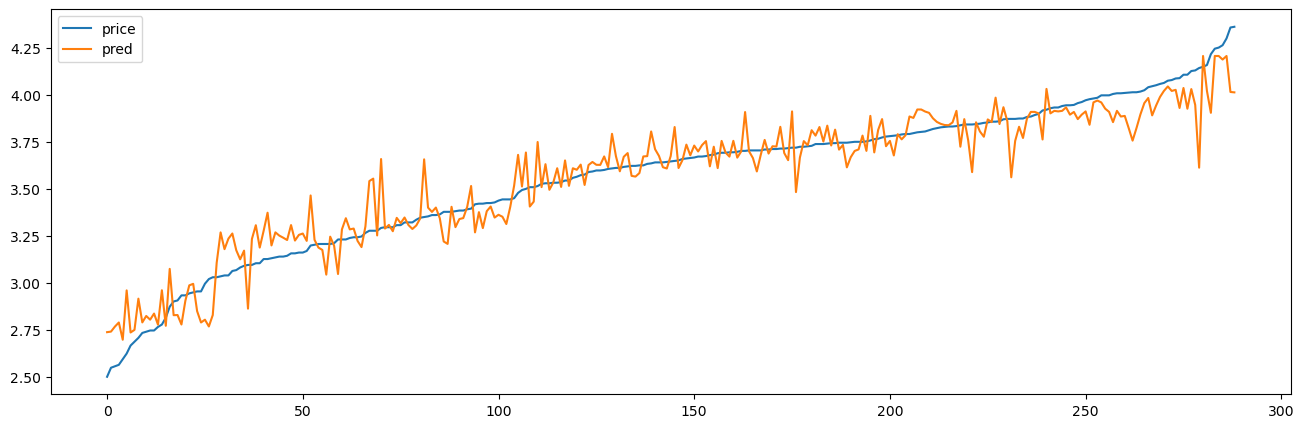

In [94]:
df_pred[['price','pred']].plot(figsize=(16,5));

## Gráficios de validación modelos de regresión

2. Gráfico de residuos vs. valores predichos: 


Un gráfico de residuos muestra los residuos (diferencias entre los valores observados y los valores predichos por el modelo) en función de los valores ajustados o las variables independientes. Este gráfico puede ayudarte a verificar si los residuos tienen algún patrón sistemático, como una relación no lineal o una heterocedasticidad.

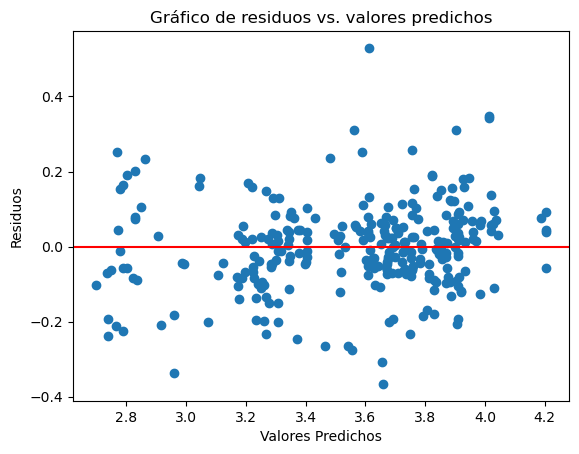

In [95]:
val_y = y
residuos = val_y - pred

plt.scatter(pred, residuos)
plt.axhline(y=0, color='red')  # Línea horizontal en cero
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos vs. valores predichos')
plt.show()


3. Histograma de residuos:

 Este gráfico muestra la distribución de los residuos del modelo. Puedes utilizar un histograma o un gráfico de densidad para visualizar cómo se distribuyen los residuos y verificar si siguen una distribución aproximadamente normal.

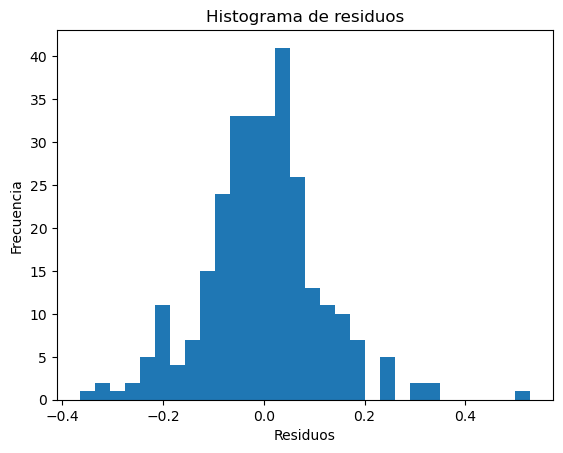

In [96]:
plt.hist(residuos, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de residuos')
plt.show()

4. Gráfico de Q-Q (cuantil-cuantil):

Este gráfico compara los cuantiles de los residuos con los cuantiles esperados de una distribución normal. Puede ayudarte a evaluar si los residuos siguen una distribución normal.

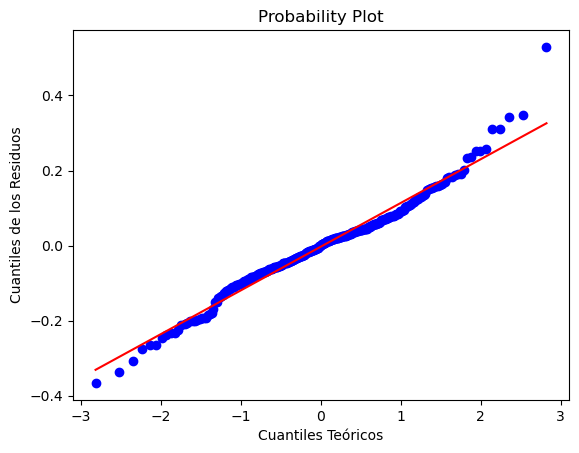

In [97]:
import scipy.stats as stats

stats.probplot(residuos, dist="norm", plot=plt)
plt.xlabel('Cuantiles Teóricos')
plt.ylabel('Cuantiles de los Residuos')
plt.show()


5. Gráfico de influencia:

Un gráfico de influencia muestra la influencia de cada observación en el ajuste del modelo. Puede ayudarte a identificar puntos atípicos o valores influyentes que pueden tener un impacto significativo en los resultados de la regresión.

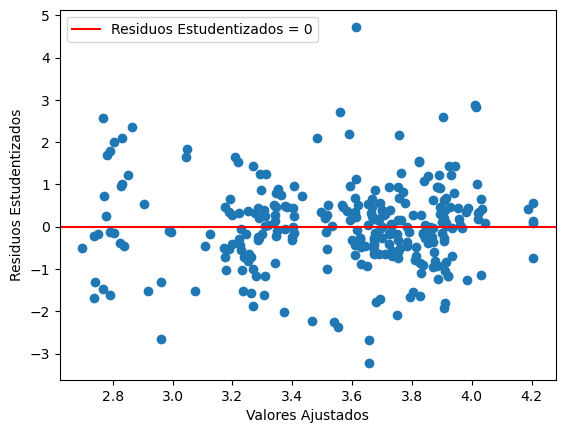

In [98]:
import statsmodels.api as sm

infl = sm.OLS(val_y, sm.add_constant(pred)).fit().get_influence()
residuos_estudentizados = infl.resid_studentized_external

plt.scatter(pred, residuos_estudentizados)
plt.axhline(y=0, color='r', linestyle='-', label='Residuos Estudentizados = 0')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos Estudentizados')
plt.legend()
plt.show()

### CREAR PIPELINE DE ENTRENAMIENTO

### Instanciar el Modelo

In [99]:
modelo = RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300, n_jobs=-1)

### Crear el pipe final de de entrenamiento

In [100]:
pipe_entrenamiento = make_pipeline(modelo)

#### Guardar el pipe final de entrenamiento

In [101]:
nombre_pipe_entrenamiento = 'pipe_entrenamiento.pickle'
ruta_pipe_entrenamiento = '../../04_Modelos/' + nombre_pipe_entrenamiento

with open (ruta_pipe_entrenamiento, mode= 'wb') as file:
    cloudpickle.dump(pipe_entrenamiento, file)


#### Entrenar el pipe final de ejecucción

In [102]:
pipe_ejecucion = pipe_entrenamiento.fit(x,y)

#### Guardar el pipe final de entrenamiento

In [103]:
nombre_pipe_ejecucion = 'pipe_ejecucion.pickle'
ruta_pipe_ejecucion = '../../04_Modelos/' + nombre_pipe_ejecucion

with open (ruta_pipe_ejecucion, mode= 'wb') as file:
    cloudpickle.dump(pipe_ejecucion, file)
